In [1]:
# Notebook configuration

ALGODIRECT_GEMINI_RESULTS_DIR = "./results/algodirect/sv7-apu11/"

GT_DIR = "/private/nas1/fvs_benchmark_datasets" # requires nfs mount

In [3]:
# Python imports

import os
import json
import re

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [4]:
#
# Algo Direct - Gemini
#

In [5]:
# Accumulate algodirect gemini results by recursively walking the results dir

csvs = []

# locate a .json files in the results data dir
for root, dir, files in os.walk(ALGODIRECT_GEMINI_RESULTS_DIR):
    for file in files:
        
        if file.endswith(".csv"):
            fpath = os.path.join(root, file)
            csvs.append(fpath)

#print(csvs)


In [6]:
# Load all csv results into one dataframe

dfs = []

for csvfile in csvs:
    # parse the file name for info
    _df = pd.read_csv(csvfile)
    parts = os.path.basename(csvfile).split("_")
    _df['implementation']=parts[1]
    _df['machine']=parts[2]
    _df['dset']=parts[3]
    _df['index']=parts[4]
    _df['numrecs']=int(parts[5])
    _df['bits']=int(parts[6])
    _df['traintime']=float(parts[7])
    _df['walltime']=float(parts[8].split(".")[0])
    dfs.append(_df)

df = pd.concat(dfs)
#print(df.columns, df.shape)

In [7]:
# Show the data

pd.reset_option('display.max_rows')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
#df

In [8]:
# compute recall via GT file

#print(df.columns, df.shape)

# get all unique dataset sizes
sizes = df['numrecs'].unique()
sizes.sort()
#print("all sizes=",sizes)

# get all unique bit sizes
bits = df['bits'].unique()
bits.sort()
#print("all bits=",bits)

# create empty ecall10 column to be computed shortly
df['recall10']= None

def hsize(numrecs):
    '''get text abbrev of raw numrecs'''
    if numrecs==10000: return "10K"
    elif numrecs==1000000: return "1M"
    elif numrecs==2000000: return "2M"
    elif numrecs==5000000: return "5M"
    elif numrecs==10000000: return "10M"
    elif numrecs==20000000: return "20M"
    elif numrecs==50000000: return "50M"
    elif numrecs==100000000: return "100M"
    elif numrecs==250000000: return "250M"
    elif numrecs==500000000: return "500M"
    else: raise Exception("Unsupported size" + str(numrecs))


# accumulate summaries for new dataframe
summaries = []

for bt in bits:
    for sz in sizes:
        # get the ground truth file for this numrecs size
        hsz = hsize(sz)
        gt_file = os.path.join(GT_DIR, "deep-%s-gt-1000.npy" % hsz)
        if not os.path.exists(gt_file):
            raise Exception("Cannot find "+ gt_file)
        gt = np.load(gt_file)
        #print(gt_file, gt.shape)
    
        # get the rows for this numrecs size
        df_sz = df[ (df['numrecs']==sz) & \
                    (df['bits']==bt) ]
        if df_sz.shape[0]==0:
            print("Nothing for bits=%d and numrecs=%d" % (bt, sz))
            continue
        elif df_sz.shape[0]!=1000:
            print("Warning: multiple runs across query set (%d,%d)" % \
                (bt,sz))
            
        # iterate all rows and compute recall
        for i in range(df_sz.shape[0]):
            # get query index
            q_i = df_sz.iloc[i, list(df.columns).index('q_index') ]
            # get the search indices for this query index
            inds = [ int(ith) \
                for ith in \
                    df_sz.iloc[i, list(df.columns).index('inds')]
                        .replace("=","-").split("-") ]
            # get the associated ground truth indices for this query for k=10
            gt10 = gt[q_i][0:10]
            # compute intersection for recall
            isec = np.intersect1d( gt10, inds)
            recall10 = len(isec)/10.0
            # apply to this row
            df_sz.at[i,'recall10'] = recall10
    
        # compute mean recall
        recall10_mean = df_sz['recall10'].mean()
    
        # compute mean search time 
        search_mean = df_sz['search_time'].mean() * 1000.0
    
        # grab the train time
        train_time = df_sz['traintime'].mean()
        
        # grab the wall import time
        wall_time = df_sz['walltime'].mean()
        
        #print(bt, sz, recall10_mean, search_mean, train_time, wall_time )
        summary = {'bits':bt, 'numrecs':sz, \
                   'recall10_mean': recall10_mean, \
                   'search_mean': search_mean, \
                   'train_time': train_time, \
                   'wall_time': wall_time }
        summaries.append(summary)

summary_df = pd.DataFrame(summaries)
print(summary_df)

print("Done")

Nothing for bits=64 and numrecs=250000000
Nothing for bits=64 and numrecs=500000000
Nothing for bits=512 and numrecs=250000000
Nothing for bits=768 and numrecs=250000000
Nothing for bits=768 and numrecs=500000000
    bits    numrecs  recall10_mean  search_mean    train_time  wall_time
0     64      10000         0.9977     6.686806      3.197599        3.0
1     64    1000000         0.9624    22.011360      2.233583        2.0
2     64    2000000         0.9474    22.492887      4.389998        4.0
3     64    5000000         0.9233    23.612933     10.721548       10.0
4     64   10000000         0.8865    24.905373     18.433649       18.0
5     64   20000000         0.8889    26.472284     35.921844       35.0
6     64   50000000         0.8343    29.009352   2889.250224     2889.0
7     64  100000000         0.7842    33.661810   6391.818142     6391.0
8    128      10000         0.9995    10.984272      4.335522        4.0
9    128    1000000         0.9926    25.994667      2.37

train time [10000, 1000000, 2000000, 5000000, 10000000, 20000000, 50000000, 100000000, 250000000, 500000000] [0.0008007314999999999, 0.0007253014444444445, 0.001285942333333333, 0.0028720794999999998, 0.005113104444444444, 0.10721183127777778, 0.18120636583333338, 1.3780876098888888, 3.6575001150000004, 4.710088842222222]
wall import time [10000, 1000000, 2000000, 5000000, 10000000, 20000000, 50000000, 100000000, 250000000, 500000000] [0.0007222222222222223, 0.0006111111111111112, 0.0011111111111111111, 0.0027222222222222222, 0.005, 0.10705555555555554, 0.1811111111111111, 1.3779444444444446, 3.6573611111111113, 4.71]


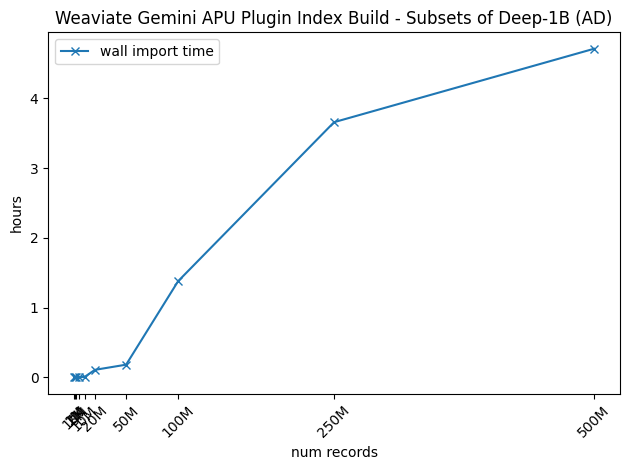

In [9]:
# Plot import/train times

# compute average train time via groupby
avg_train_time = \
    summary_df.groupby( [ 'numrecs' ] ) ['train_time'].mean()

# compute average wall import time via groupby
avg_wall_import_time = \
    summary_df.groupby( [ 'numrecs' ] ) ['wall_time'].mean()

# get the plot points for train time
xs = []
ys = []
for idx in avg_train_time.index:
    x = idx
    xs.append(x)
    y = avg_train_time[idx]/(60.0*60.0)
    ys.append(y)
print("train time", xs,ys)

# get the plot points for wall import time
wxs = []
wys = []
for idx in avg_wall_import_time.index:
    x = idx
    wxs.append(x)
    y = avg_wall_import_time[idx]/(60.0*60.0)
    wys.append(y)
print("wall import time", wxs,wys)

# plot the lines and label the plot
fig, ax = plt.subplots()
#ax.plot(xs,ys, marker='x', label="train time")
ax.plot(wxs,wys, marker='x', label="wall import time")
ax.set_ylabel('hours')
ax.set_xlabel('num records')
ax.set_xticks(xs)
ax.set_xticklabels(['10K','1M','2M','5M','10M','20M','50M', '100M', '250M','500M'], rotation = 45)
ax.set_title("Weaviate Gemini APU Plugin Index Build - Subsets of Deep-1B (AD)")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/weaviate_gemini_build_time_ad.png")

# TODO:  plot the variance at each X

[0.9976999999999996, 0.9623999999999977, 0.9473999999999974, 0.9232999999999953, 0.8864999999999956, 0.888899999999996, 0.8342999999999965, 0.7841999999999973] [6.686806, 22.01136, 22.492887, 23.612932999999998, 24.905372999999997, 26.472284000000002, 29.009352, 33.66181]
[0.9994999999999998, 0.992599999999999, 0.990499999999999, 0.9818999999999986, 0.9693999999999966, 0.973899999999997, 0.9557999999999967, 0.9305999999999961, 0.8959999999999958, 0.8684999999999959] [10.984272, 25.994667, 26.687728999999997, 28.363956, 29.277286, 31.838137000000003, 36.103184999999996, 41.506008, 72.141179, 79.77100700000001]
[0.9999, 0.9994999999999998, 0.9986999999999998, 0.9979999999999998, 0.9941999999999995, 0.9957999999999997, 0.9899999999999988, 0.9847999999999982, 0.9766999999999975, 0.9634999999999969] [11.066429000000001, 26.591203, 26.907425, 29.447868, 30.555616999999998, 33.727452, 44.931062999999995, 51.262914, 63.741886, 113.749056]
[1.0, 0.9995999999999999, 0.9997999999999999, 0.9990999

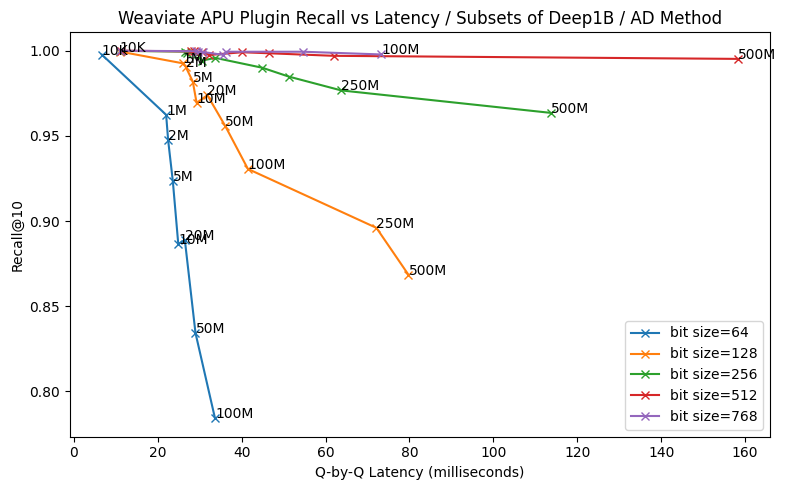

In [10]:
# plot Gemini/APU plugin recall vs latency

# get unique gem bit sizes
bits = summary_df['bits'].unique()

# prepare one plot
fig, ax = plt.subplots(figsize=(8,5))

# collect data points for the line for each bit size and plot each line
for bt in bits: # we don't need to show 512 and 768

    # TODO:  Needs a CPUs inner loop
    
    # compute mean of average recall_10 grouped by num records
    df_means = \
        summary_df[ summary_df['bits']==bt ]\
            .groupby( [ 'numrecs' ] )\
            .mean(['recall_10','search_mean'])
 
    dset_sizes = [ idx for idx in list(df_means.index) ]
    dset_sizes.sort()
    #print(dset_sizes)

    # get the plot points for recall vs latency
    recalls = [ r for r in list(df_means['recall10_mean']) ]
    latencies = [ l for l in list(df_means['search_mean']) ]
    print(recalls, latencies)

    # plot the line
    ax.plot(latencies,recalls, marker='x', label='bit size=%d' % bt)

    # label each point
    for i,j,s in zip(latencies,recalls,dset_sizes):
        off = (0,0)
        if bt==768:
            if s==max(dset_sizes): off = (0,0)
            else: continue
        elif bt==512:
            if s==max(dset_sizes): off = (0,0)
            else: continue
        elif bt==256:
            if s in dset_sizes[-2:]: off = (0,0)
            else: continue
        ##if s==10000 and bit_size==64.0: off=(-1,-0.002) 
        #if s==2000000 and bit_size==256.0: off=(00,-0.002) 
        ax.annotate(hsize(s),  xy=(i + off[0], j + off[1]))

ax.set_xlabel("Q-by-Q Latency (milliseconds)")
ax.set_ylabel("Recall@10")
ax.set_title("Weaviate APU Plugin Recall vs Latency / Subsets of Deep1B / AD Method")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/weaviate_apu_plugin_recall_vs_latency_ad.png")
